# Set up file 

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
import scipy.interpolate
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Python/python_from_R/Holocene/sampled_models/plotting_files/')
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Deglaciation/modules/')
from keyname import keyname as kn
import config
from plott import plott
import scipy.interpolate
# from mpl_toolkits.basemap import Basemap
matplotlib.use('agg')
from Cross_section import Cross_section
from Proxy_graph_masked import Proxy_graph
import Config
# from Map_plot import Map_plot
from collections import Counter
import scipy.stats as stats
from pylab import *
rcParams['legend.numpoints'] = 1
from matplotlib.ticker import MaxNLocator
from IPython import embed
import os
import ast
from matplotlib import gridspec
import itertools
import xarray as xr
import json

%matplotlib inline

In [2]:
# Set Formatting variables
alpha = 0.5
point_color_dp = (0,0,1,alpha)#'blue'
point_color_shw = (1,0,0,alpha)#'red'
line_color_dp = 'cyan'
line_color_shw = 'magenta'
lw = 4
edgewidth=0.5
size = 40
fontsize = 20

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']


# Load stored results

In [3]:
# Load the oceanic d13C data
results_dict = json.loads(open("Data/results_dict.json","r").read())

In [4]:
# Load Schneider 2013 d13CO2 (permil) penultimate deglaciation data
df_d13CO2_PD = pd.read_csv('Data/d13Catm_Monte-Carlo-155-105.tab',delimiter='\t')

# Read in Last deglaciation d13CO2 (permil) data from Eggleston 2016
df_d13CO2_LD = pd.read_csv('Data/eggleston16paleo_d13CO2_spline.tab',delimiter='\t')


In [5]:
# Start off by only looking at the Atlantic
basin=['Atlantic']

# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[config.period_list,basin]))).rename(
    columns={0:'period',1:'basin'})

# Create a dictionary to store the volume weighted dataframes in
volume_weighted_dfs_dict = {}

# Loop over all the combinations
for period,basin in zip(
    combinations['period'],
    combinations['basin']
    ):
    
    # Get the hashkey
    hashkey_avg_age = kn(basin=basin,period=period[1],vartype='d13C_avg_age')
    
    # Get the dataframe of the relevant results
    df_avg_age = pd.DataFrame.from_dict(results_dict[hashkey_avg_age])
    
    volume_weighted_dfs_dict.update({
        tuple([period[1],basin]) : df_avg_age
    })

# Calculate d13C time-depth mv avg

In [6]:
########################################
    # Create auxillary functions
########################################

def slice_anomaly_calcuator(original_array):
    '''Function that returns an array where each time slice (axis=1) is the anomaly of that time slice (slice-slice_mean)'''

    # Create an empty array with the same dims as the original array
    gridded_array_anomaly = original_array.copy()
    
    # Loop over each time slice (axis=1)
    for x in np.arange(0,original_array.shape[1],1):
        
        # Calculate the slice mean
        slice_mean = np.mean(original_array[:,x])
        
        # Find the anomaly of the slice
        gridded_array_anomaly[:,x] = original_array[:,x]/slice_mean
        
    # Return the anomaly array
    return(gridded_array_anomaly)

def volume_weighted_mean_anomaly_calculator(original_array,volume_weighted_dfs_dict,period,loc):
    '''Function that takes the gridded array and the volume weighted mean results and calculates the anomaly between them'''
    
    # Get the dataframes of the volume weighted means
    df_volume_means = volume_weighted_dfs_dict[tuple([period[1],'Atlantic'])]

    # Create an empty array that will be filled with the mean volume weights for each time slice
    mean_array = np.empty(gridded_array.shape)

    # Fill each time slice with the volume weighted mean
    for indx in np.arange(0,mean_array.shape[0],1):
        mean_array[indx,:] = np.array(df_volume_means.d13C)

    # Calculate the anomaly value
    gridded_array_anomaly = gridded_array - mean_array
    
    return(gridded_array_anomaly)

def calculate_dividing_depth(df_samples):
    '''Function that takes the samples, loops over a range of depths, and finds the ideal split depth.
        It does this by finding the minimum of the sum of squared errors.
        Takes a dataframe (df_samples) with both a Dep and a d13C column.
        Returns a single value; the dividing depth (m)'''
    
    # Make a list of depths to use as the dividing depth
    depth_list = np.arange(220,5000,100)

    # Create an empty dictionary to put all the total sum of squared errors into
    SSQ_total_dict = {}

    # Loop over the list of depths, using each one to split into AABW and NADW
    for depth in depth_list:

        # If this depth was used as the split depth, get the samples that would be in each
        df_samples_AABW = df_samples[(df_samples.Dep > depth)]
        df_samples_NADW = df_samples[(df_samples.Dep <= depth)&(df_samples.Dep>2000)] 

        # Calculate the numerical means of each cluster
        AABW_mean = np.nanmean(df_samples_AABW.d13C)
        NADW_mean = np.nanmean(df_samples_NADW.d13C)

        # Calculate the sum of squared error for the AABW cluster
        AABW_deviation = df_samples_AABW.d13C-AABW_mean
        AABW_SSQ = np.sum([x**2 for x in AABW_deviation])

        # Calculate the sum of squared error for the NADW cluster    
        NADW_deviation = df_samples_NADW.d13C-NADW_mean
        NADW_SSQ = np.sum([x**2 for x in NADW_deviation])  

        # Calculate the total sum of squared error for both boxes
        SSQ_total = (NADW_SSQ + AABW_SSQ)

        # Add the total sum of squared error into the dictionary
        SSQ_total_dict.update({
            depth : SSQ_total
        })

    # Create a dataframe from the dictionary
    df_SSQ = pd.DataFrame.from_dict(SSQ_total_dict,orient='index').reset_index(drop=False)

    # Rename the columns something that is logical
    df_SSQ.columns = ['depth','SSQ']

    # Get the dividing depth, which is where there is a minimum in the sum of squared error total
    dividing_depth = df_SSQ[df_SSQ.SSQ==np.min(df_SSQ.SSQ)].depth.reset_index(drop=True)[0]

    return(dividing_depth)

In [7]:
def moving_average_slice_array(df_samples,lat_min,lat_max):
    ################################################
                    # Grid Creation
    ################################################

    # Get a latitudinal slice of the data
    df_samples = df_samples[(df_samples.Lat> lat_min) & (df_samples.Lat < lat_max)]

    # Create depth grid for the data
    depth_range_1 = np.arange(1000,6000,250)
    depth_range_2 = np.arange(1000+250,6000+250,250+250)
    depth_grid = []
    for dep_shw, dep_dp in zip(depth_range_1,depth_range_2):
        depth_grid.append(np.mean([dep_shw,dep_dp]))

    # Create period grid for the data
    period_grid = np.unique(df_samples.age)

    ################################################
                # Determining grid as dicts
    ################################################

    # Create empty dictionary to added period slice dictionaries for each depth-gridded dictionaries
    gridded_dict = {}

    # Create an empty dictionary for the split depth
    split_depth_dict = {}
    
    # Loop over the 'age' bound in of the period grid
    for age in period_grid:

        # Extract from all samples only the ones for the right period grid
        period_slice = df_samples[df_samples.age==age]
        
        # Calculate the ideal split depth
        dividing_depth = calculate_dividing_depth(period_slice)

        # Add dividing depth to dictionary
        split_depth_dict.update(
            {age : int(dividing_depth)}
        )
        
        # Drop the NA values (why are they here?)
        period_slice = period_slice.dropna()

        # Create empty dictionary of the moving average of depth for this period slice
        moving_avg_depth_dict = {}

        # Loop over a depth slice (shw=min (shallowest) depth, dp=max (deepest) depth)
        for dep_shw, dep_dp in zip(depth_range_1,depth_range_2):

            # Get all values over which there is data
            depths = list(period_slice.Dep[(period_slice.Dep>dep_shw) & (period_slice.Dep<dep_dp)])
            d13C_depth_mean = np.mean(period_slice[period_slice.Dep.isin(depths)].d13C)

            # Add this interpolated d13C at this depth to a dictionary
            moving_avg_depth_dict.update(
                {np.mean([dep_shw,dep_dp]):d13C_depth_mean}
            )

        # For this period slice, add the data which has been gridded w/ dep to dictionary
        gridded_dict.update({
            age : moving_avg_depth_dict
        })

    ################################################
            # Dict to array, interp nan w/ dep
    ################################################

    # Create a 2D array on the period-depth grid fron the dictionary
    gridded_array = np.array(pd.DataFrame.from_dict(gridded_dict,orient='index').T)

    # Create new grid for the interpolation of the points
    gridded_array_interp = gridded_array.copy()

    # Interpolate the points over each period slice
    for period_slice in np.arange(0,gridded_array.shape[1],1):
        nans, x = np.isnan(gridded_array_interp[:,period_slice]), lambda z: z.nonzero()[0]
        gridded_array_interp[:,period_slice][nans] = np.interp(x(nans), x(~nans), gridded_array_interp[:,period_slice][~nans])

    # Fill the outside grid back in (since you can't interpolate the edges of the matrix)
    gridded_array_interp[1,:] = gridded_array[1,:]
    gridded_array_interp[-1,:] = gridded_array[-1,:]
    
    # Transform variables to xarrays
    gridded_array = xr.DataArray(gridded_array,coords=[depth_grid,period_grid],dims=['depth','period'])
    gridded_array_interp = \
        xr.DataArray(gridded_array_interp,coords=[depth_grid,period_grid],dims=['depth','period'])
    
    return(df_samples,gridded_array,gridded_array_interp,split_depth_dict)


In [8]:
# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[config.period_list,config.loc_list]))).rename(
    columns={0:'period',1:'loc'})

# Loop over all the combinations
for period,loc in zip(
    combinations['period'],
    combinations['loc']
    ):

    # get the results dict hashkey for this results
    hashkey = kn(basin='Atlantic',period=period[1],vartype='df_d13C_raw')
    
    # Run moving average function
    df_loc_samples, gridded_array, gridded_array_interp, split_depth_dict = \
        moving_average_slice_array(pd.DataFrame(results_dict[hashkey]),np.min(loc[0]),np.max(loc[0]))
    
    # Calculate the anomaly arrays
    gridded_array_anomaly = volume_weighted_mean_anomaly_calculator(gridded_array,volume_weighted_dfs_dict,period,loc)
    gridded_array_interp_anomaly = volume_weighted_mean_anomaly_calculator(gridded_array_interp,volume_weighted_dfs_dict,period,loc) 
    
    # Save the results
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='df_mv_avg_samples'): \
        df_loc_samples.to_dict()
    })    
       
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='mv_avg_gridded_array'): \
        gridded_array.to_dict()
    })      
    
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='mv_avg_gridded_array_anomaly'): \
        gridded_array_anomaly.to_dict()
    })    
    
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='mv_avg_gridded_array_interp'): \
        gridded_array_interp.to_dict()
    })
    
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='mv_avg_gridded_array_interp_anomaly'): \
        gridded_array_interp_anomaly.to_dict()
    })    
    
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='split_depth'): \
        split_depth_dict
    })    
    

/srv/ccrc/data06/z5145948/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice
/srv/ccrc/data06/z5145948/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


# Save the data

In [9]:
with open('Data/results_dict.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plot the Results

In [10]:

def plotting_moving_avg(ax,results_dict,period,loc,vmin,vmax,axis_count,**kwargs):
    
    # Determine from kwargs if you should be finding the anomaly. If it is anomaly, define name_append to be anomaly
    try:
        if kwargs['anomaly']==True:
            name_append='_anomaly'
        elif kwargs['anomaly']==False:
            name_append=''
        else:
            print('You have provided an invalid argument for anomaly. \n Only True or False are accepted')
    except:
        # The default is no anomaly
        name_append=''
        
    # get the results dict hashkey for this results
    hashkey_mv_avg_samples = \
        kn(basin='Atlantic',period=period[1],loc=loc[1],vartype='df_mv_avg_samples')
    
    hashkey_mv_avg_gridded_array = \
        kn(basin='Atlantic',period=period[1],loc=loc[1],vartype='mv_avg_gridded_array{}'.format(name_append))
    
    hashkey_mv_avg_gridded_array_interp = \
        kn(basin='Atlantic',period=period[1],loc=loc[1],vartype='mv_avg_gridded_array_interp{}'.format(name_append))

    hashkey_split_depth = \
        kn(basin='Atlantic',period=period[1],loc=loc[1],vartype='split_depth')    

    # Extract relevant data from results dictionary
    gridded_array = xr.DataArray.from_dict(results_dict[hashkey_mv_avg_gridded_array])
    gridded_array_interp = xr.DataArray.from_dict(results_dict[hashkey_mv_avg_gridded_array_interp])
    df_loc_samples = pd.DataFrame.from_dict(results_dict[hashkey_mv_avg_samples])
    df_split_depth = pd.DataFrame.from_dict(results_dict[hashkey_split_depth],orient='index')    
    
    ################################################
                    # Plotting points
    ################################################

#     # Show a scatter of the points of the interpolated (with period) d13C moving average
#     ax.scatter(df_loc_samples.age,
#                df_loc_samples.Dep,
#                c=df_loc_samples.d13C,edgecolor='k',
#                cmap=cmap)

    ################################################
                    # Plotting Graph
    ################################################

    # Plot the filled contour of the evolution of NAWD/AABW w/ period and depth

    (True if axis_count=='even' else False)
    colour_bar_input = \
        xr.plot.contourf(gridded_array,
                     zorder=0,
                     cmap=cmap,
                     levels=20,
                     vmin=vmin,
                     vmax=vmax
                    )
    
    xr.plot.contourf(gridded_array_interp,
                     hatches=['.'],
                     zorder=-1000,
                     cmap=cmap,
                     levels=20,
                     vmin=vmin,
                     vmax=vmax,
                     add_colorbar=False
                    )
    
    ################################################
                 # Plot the split depth
    ################################################    
    
    ax.plot(df_split_depth,c='k')    

    ################################################
                    # Format the axes
    ################################################
    
    ax.set_xlabel('Time (ka BP)')
    
    ax.invert_yaxis()
    ax.invert_xaxis()   
    
    return(ax)

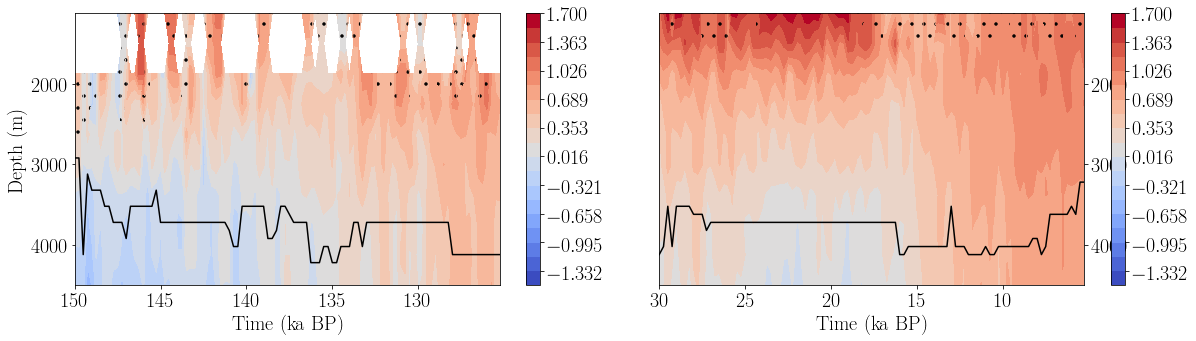

In [11]:
# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[config.loc_list,config.period_list]))).rename(columns={0:'loc',1:'period'})

################################################
                # Set up
################################################

# Set parameters for the graph
cmap = 'coolwarm'
vmin=-1.5
vmax=1.7

# store subplots in lists for later
even_axes = []
odd_axes = []

# Set up graph
fig = plt.figure(figsize = (20,5))
gs_list = list(gridspec.GridSpec(len(config.loc_list), len(config.period_list)))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

# Loop over all the combinations
for period,loc,gs,gs_count in zip(
    combinations.period,combinations['loc'],gs_list[0:2],np.arange(0,len(list(gs_list)),1)):
    
    # get the correct subplot
    ax = plt.subplot(gs)
    
    # Define if it's an even or add axis, for formatting later
    if (gs_count/2)%1!=0:
        even_axes.append(ax)
        axis_count = 'even'
    else:
        odd_axes.append(ax)
        axis_count = 'odd'        
    
    # Run the plotting function for this set of vars
    ax = plotting_moving_avg(ax,results_dict,period,loc,vmin,vmax,axis_count)
    
# ##### Add d13CO2 data
# ax3 = plt.subplot(gs_list[2])
# ax3.plot(df_d13CO2_PD['Gas_age'],df_d13CO2_PD['d13CO2'],'k-')
# ax3.set_xlim([150,125])
# ax3.set_ylim([-7,-6.3])
# ax3.set_xlabel('Time (ka BP)')

# ax4 = plt.subplot(gs_list[3])
# ax4.plot(df_d13CO2_LD['Gas_age'],df_d13CO2_LD['d13CO2'],'k-')
# ax4.set_xlim([30,5])
# ax4.set_ylim([-7,-6.3])
# ax4.set_yticks([])
# ax4.set_xlabel('Time (ka BP)')

# label lefthand yaxes
[ax.set_ylabel('Depth (m)') for ax in odd_axes]
# turn off righthand labels
[ax.set_ylabel('') for ax in even_axes]

# Move righthand subplots yaxis ticks right
[ax.yaxis.tick_right() for ax in even_axes]
    
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)                                                    

plt.subplots_adjust(wspace=0.1,hspace=0.1)

plt.show()

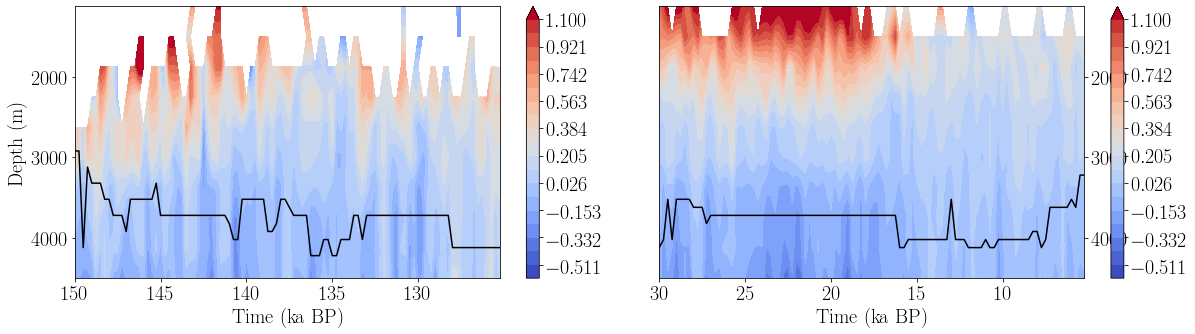

In [12]:
# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[config.loc_list,config.period_list]))).rename(columns={0:'loc',1:'period'})

################################################
                # Set up
################################################

# Set parameters for the graph
cmap = 'coolwarm'
vmin=-.6
vmax=1.1

# store subplots in lists for later
even_axes = []
odd_axes = []

# Set up graph
fig = plt.figure(figsize = (20,5))
gs_list = gridspec.GridSpec(len(config.loc_list), len(config.period_list))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

# Loop over all the combinations
for period,loc,gs,gs_count in zip(
    combinations.period,combinations['loc'],gs_list,np.arange(0,len(list(gs_list)),1)):
    
    # get the correct subplot
    ax = plt.subplot(gs)
    
    # Define if it's an even or add axis, for formatting later
    if (gs_count/2)%1!=0:
        even_axes.append(ax)
        axis_count = 'even'
    else:
        odd_axes.append(ax)
        axis_count = 'odd' 
    
    # Run the plotting function for this set of vars
    ax = plotting_moving_avg(ax,results_dict,period,loc,vmin,vmax,axis_count,anomaly=True)

# label lefthand yaxes
[ax.set_ylabel('Depth (m)') for ax in odd_axes]
# turn off righthand labels
[ax.set_ylabel('') for ax in even_axes]

# Move righthand subplots yaxis ticks right
[ax.yaxis.tick_right() for ax in even_axes]
    
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)                                                    

plt.subplots_adjust(wspace=0.1,hspace=0.1)

plt.show()

In [16]:
calculate_dividing_depth(df_loc_samples)

/srv/ccrc/data06/z5145948/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


(3720, 1179.6867324156096)

In [15]:
def calculate_dividing_depth(df_samples):
    '''Function that takes the samples, loops over a range of depths, and finds the ideal split depth.
        It does this by finding the minimum of the sum of squared errors.
        Takes a dataframe (df_samples) with both a Dep and a d13C column.
        Returns a single value; the dividing depth (m)'''
    
    # Make a list of depths to use as the dividing depth
    depth_list = np.arange(220,5000,100)

    # Create an empty dictionary to put all the total sum of squared errors into
    SSQ_total_dict = {}

    # Loop over the list of depths, using each one to split into AABW and NADW
    for depth in depth_list:

        # If this depth was used as the split depth, get the samples that would be in each
        df_samples_AABW = df_samples[(df_samples.Dep > depth)]
        df_samples_NADW = df_samples[(df_samples.Dep <= depth)&(df_samples.Dep>2000)] 

        # Calculate the numerical means of each cluster
        AABW_mean = np.nanmean(df_samples_AABW.d13C)
        NADW_mean = np.nanmean(df_samples_NADW.d13C)

        # Calculate the sum of squared error for the AABW cluster
        AABW_deviation = df_samples_AABW.d13C-AABW_mean
        AABW_SSQ = np.sum([x**2 for x in AABW_deviation])

        # Calculate the sum of squared error for the NADW cluster    
        NADW_deviation = df_samples_NADW.d13C-NADW_mean
        NADW_SSQ = np.sum([x**2 for x in NADW_deviation])  

        # Calculate the total sum of squared error for both boxes
        SSQ_total = (NADW_SSQ + AABW_SSQ)

        # Add the total sum of squared error into the dictionary
        SSQ_total_dict.update({
            depth : SSQ_total
        })

    # Create a dataframe from the dictionary
    df_SSQ = pd.DataFrame.from_dict(SSQ_total_dict,orient='index').reset_index(drop=False)

    # Rename the columns something that is logical
    df_SSQ.columns = ['depth','SSQ']

    # Get the dividing depth, which is where there is a minimum in the sum of squared error total
    dividing_depth = df_SSQ[df_SSQ.SSQ==np.min(df_SSQ.SSQ)].depth.reset_index(drop=True)[0]

    return(dividing_depth,np.min(df_SSQ.SSQ))